## Daily Linear Regression

The goal is to reduce the hourly noise and predict the daily consumption and then decompose the daily predictions into hourly

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd() + "/../..")
import feature_engineering as fe
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from utils import combine_data
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')
random_state=123456789
np.random.seed(123456789)
from utils import plot_correlogram, nmae, nmae_scorer, mape_scorer, mean_squared_error_scorer, corr_metric_scorer
from data_processing import DataProcessAggregateDaily
from typing import Dict
from sklearn.utils import shuffle
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import learning_curve
#models
import statsmodels.api as sm
import lightgbm as lgb
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope
import hyperopt
import tqdm

#vis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo

## Read Data

In [2]:
meta, data =pd.read_pickle("../../data/forecast_data_2020.p")

In [3]:
cluster_idx = pd.read_csv("../../data/cluster_idx.csv")

In [4]:
homes_indexes = data.columns.get_level_values(0).unique()

In [5]:
homes_indexes

Index(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801',
       '987', '299', '640', '744', '241', '200', '441', '192', '621', '313',
       '464', '424', '993', '598', '514', '268', '745', '927', '945', '352',
       '980', '644', '683', '244', '677', '351', '118', '595', '255', '554',
       '318', '743', '947', '480', '219', '780', '909', '977', '272', '246',
       '521', '842', '267', '396', '290', '601', '901', '260', '618', '629',
       '238', '231', '875', '889', '340', '906', '604', '525', '460', '130',
       '363', '250', '666', '438', '986', '462', '188', '763', '923', '925',
       '822', '131', '456', '624', '827', '474', '859', '912', '194', '706',
       '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'],
      dtype='object')

## Aggregate to Daily per house

In [6]:
data_daily = DataProcessAggregateDaily(data,meta).main(generate_feature=False)

## Feature Engineering

### Target
Since at time step T we need to predict the value given at step T+1, but at step T
we only know values from step T-1 (make prediction on Wednesday about Constumption on Thursday, given known values of consumption only at Teusday, thus we need to shift by 2 * 24h = 48h, since we workd on daily data now, thus we need to shift by 2 days

In [7]:
target = make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(-2),fe.CastType(float), fe.ApplyLogTransformation())

### Current consumption
consumption at step T-1 won't require any shift

In [8]:
prev_consumption = make_pipeline(fe.FeatureSelector('consumption'), fe.CastType(float), fe.ApplyLogTransformation())
rolling_mean = fe.make_union(*(make_pipeline(fe.FeatureSelector('consumption'),fe.CastType(float),fe.ApplyLogTransformation(), fe.ApplyRollingWindowMean(i) ) for i in range(2,8)))

### Weather

Note all weather prediction for T is given at step T, thus we need to shift for 2d the same as target 

In [9]:
temperature = make_pipeline(fe.FeatureSelector('avg_temperature'), fe.CalcShift(-2), fe.CastType(float))
humidity = make_pipeline(fe.FeatureSelector('avg_humidity'), fe.CalcShift(-2), fe.CastType(float))
cloudiness = make_pipeline(fe.FeatureSelector('avg_cloudiness'), fe.CalcShift(-2), fe.CastType(float))

### Exctract WeekDay

In [10]:
week_day =  make_pipeline(fe.FeatureSelector('agg_index'), fe.ExtractWeekDay(), fe.OneHot(drop_first=True))

### Extract season name from date

In [11]:
season = make_pipeline(fe.FeatureSelector('agg_index'), fe.ExtractSeason(), fe.OneHot(drop_first=True))

### Combine Features

In [12]:
feature_union = fe.make_union(prev_consumption,
                              temperature,
                              humidity,
                              cloudiness,
                              week_day,
                              season,
                              target
                              )
feature_union

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('casttype', CastType()),
                                                      ('applylogtransformation',
                                                       ApplyLogTransformation())])),
                                     ('pipeline-2',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='avg_temperature')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-2)),
                                                      ('ca...
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='agg_index')),
                                                      ('extractseason',
                                                       ExtractSeason()),
                                                      ('onehot',
                                                       OneHot(drop_first=True))])),
                                     ('pipeline-7',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-2)),
                                                      ('casttype', CastType()),
                                                      ('applylogtransformation',
                                                       ApplyLogTransformation())]))])

## Transform

In [13]:
def create_samples(home_indexes_subsample):
    df_dict = {}
    for home_i in list(home_indexes_subsample):
        if home_i in ["268"]: # outlier
            continue
        temp_df = data_daily[home_i]
        temp_df["agg_index"] = temp_df.index
        temp_df = feature_union.fit_transform(temp_df)
        rolling_mean_ = rolling_mean.fit_transform(data_daily[home_i])
        temp_df = temp_df.merge(rolling_mean_, left_index=True, right_index=True, how="inner")
        temp_df["ev"] = meta[home_i]["has_electric_vehicle"] +0
        temp_df["cluster_idx"] = cluster_idx["clusters"][cluster_idx["home_num"] == int(home_i)].values[0]
        temp_df["home_num"] = home_i

        df_dict[home_i] = temp_df
    return df_dict

#Train data
train_homes_indexes_subsample = np.random.choice(homes_indexes,80,replace =False)
df_dict_train = create_samples(train_homes_indexes_subsample)
df_train = combine_data(df_dict_train)

#Test data
test_homes_indexes_subsample = [i for i in homes_indexes if i not in train_homes_indexes_subsample]
df_dict_test = create_samples(test_homes_indexes_subsample)
df_test = combine_data(create_samples(df_dict_test))

In [14]:
df_train.columns

Index(['consumption', 'forward_avg_temperature_2', 'forward_avg_humidity_2',
       'forward_avg_cloudiness_2', 'week_day_workday', 'season_Spring',
       'season_Summer', 'season_Winter', 'forward_consumption_2',
       'rolling_mean_2_consumption', 'rolling_mean_3_consumption',
       'rolling_mean_4_consumption', 'rolling_mean_5_consumption',
       'rolling_mean_6_consumption', 'rolling_mean_7_consumption', 'ev',
       'cluster_idx', 'home_num'],
      dtype='object')

In [22]:
FEATURES = ['consumption', 'forward_avg_temperature_2', 'forward_avg_humidity_2',
        'season_Spring',
       'season_Summer', 'season_Winter',
       'rolling_mean_7_consumption', 'ev', 'cluster_idx']
TARGET = 'forward_consumption_2'

In [23]:
# Since we transformed the problem from Time-Series to Tabular, we allowed to shuffle it
df_train = shuffle(df_train)
df_test = shuffle(df_test)
# df_train = df_train.reset_index().sort_values(by=["time","home_num"]).set_index("time")
# df_test = df_test.reset_index().sort_values(by=["time","home_num"]).set_index("time")

X_train, y_train = df_train[FEATURES], df_train[TARGET]
X_test, y_test = df_test[FEATURES], df_test[TARGET]

In [24]:
print(X_train.shape)

(28282, 9)


In [25]:
print(X_test.shape)

(7160, 9)


In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28282 entries, 2020-08-25 to 2020-06-24
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   consumption                 28282 non-null  float64
 1   forward_avg_temperature_2   28282 non-null  float64
 2   forward_avg_humidity_2      28282 non-null  float64
 3   season_Spring               28282 non-null  uint8  
 4   season_Summer               28282 non-null  uint8  
 5   season_Winter               28282 non-null  uint8  
 6   rolling_mean_7_consumption  28282 non-null  float64
 7   ev                          28282 non-null  int64  
 8   cluster_idx                 28282 non-null  int64  
dtypes: float64(4), int64(2), uint8(3)
memory usage: 1.6+ MB


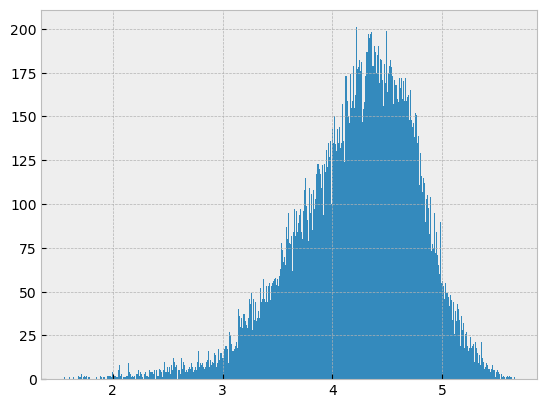

In [27]:
plt.hist(y_train, bins = 500)
plt.show()

Since the LR model is given of the form y ~ N(b*x+a, std), and our target variable is right skewed, it is worth to consider other model from GLM series

## Check Params Linear Signifance

In [29]:
mod = sm.OLS(y_train[:10000],X_train.iloc[:10000],prepend=True)
res = mod.fit()
print(res.summary())

                                  OLS Regression Results                                  
Dep. Variable:     forward_consumption_2   R-squared (uncentered):                   0.996
Model:                               OLS   Adj. R-squared (uncentered):              0.996
Method:                    Least Squares   F-statistic:                          2.681e+05
Date:                   Thu, 13 Oct 2022   Prob (F-statistic):                        0.00
Time:                           13:54:02   Log-Likelihood:                         -1198.9
No. Observations:                  10000   AIC:                                      2416.
Df Residuals:                       9991   BIC:                                      2481.
Df Model:                              9                                                  
Covariance Type:               nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.

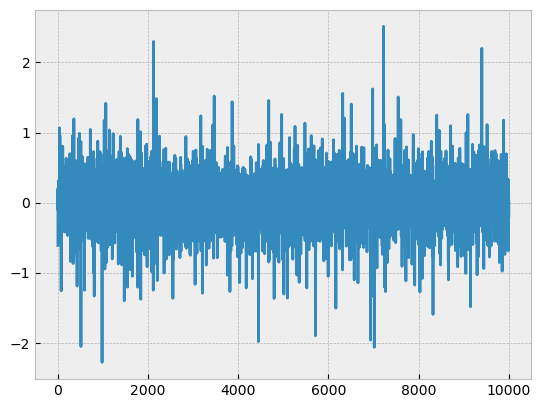

In [30]:
plt.plot(res.resid.values)

## Model Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

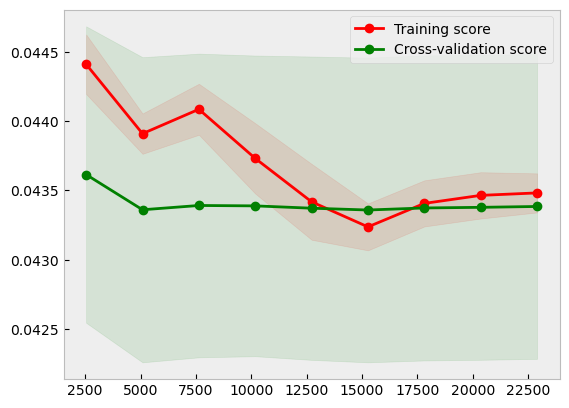

In [32]:
SCORING = nmae_scorer

train_sizes, train_scores, test_scores =learning_curve(model,
                                                       X_train,
                                                       y_train,
                                                       scoring=SCORING,
                                                       train_sizes=np.array([i/10 for i in range(1,10)]),
                                                       cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# Plot learning curve
plt.grid()
plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
plt.legend(loc="best")

Text(0.5, 1.0, 'Top 20 feature imporance')

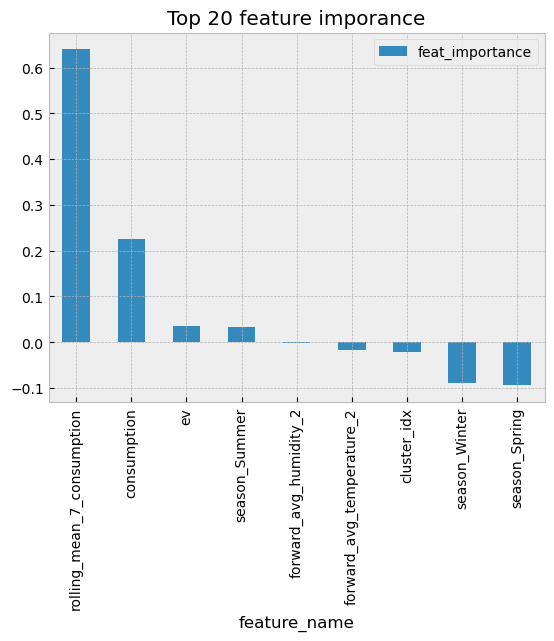

In [33]:
top = 20
df_feat = (
    pd.DataFrame({"feat_importance": model.coef_,
                  "feature_name": X_train.columns})
    .sort_values(by="feat_importance", ascending=False)
          )
df_feat.head(top).plot.bar(x="feature_name", y ="feat_importance")
plt.title(f"Top {top} feature imporance")

# Model Prediction on DAILY Consumption
## Model Prediction on Individual House Train

In [34]:
df_dict_train.keys()

dict_keys(['246', '859', '618', '987', '744', '404', '464', '241', '743', '854', '598', '255', '299', '993', '222', '424', '412', '677', '260', '906', '290', '583', '604', '644', '980', '340', '123', '244', '192', '219', '890', '118', '875', '621', '131', '460', '480', '484', '363', '657', '595', '313', '666', '188', '957', '947', '763', '554', '780', '438', '822', '927', '250', '272', '600', '852', '267', '999', '629', '514', '745', '889', '601', '261', '130', '231', '640', '992', '113', '801', '462', '525', '977', '318', '441', '909', '351', '683', '912'])

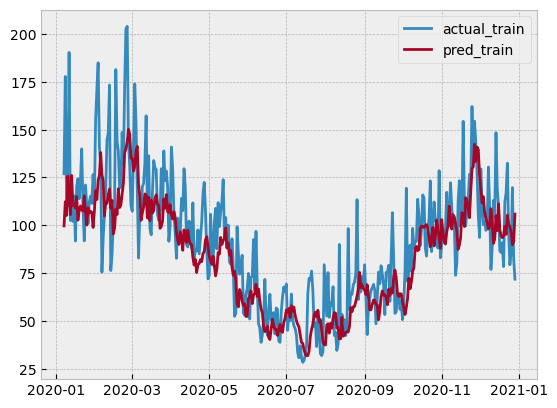

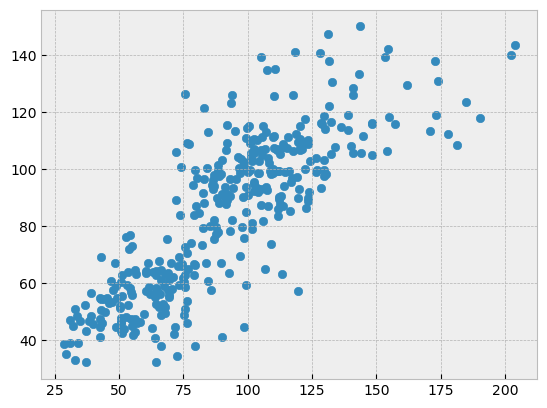

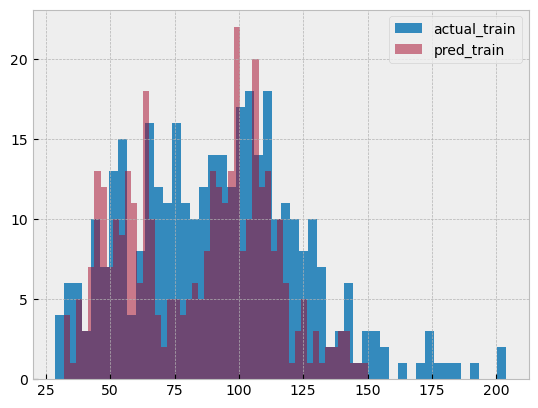

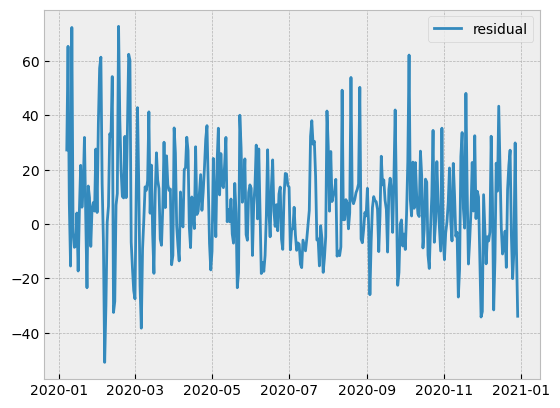

In [35]:
home_num = '246'
X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
pred = model.predict(X_train)
pred_home_train_single = pd.DataFrame({
                            # "actual": y_train,
                            # "pred": pred,
                            "actual": np.exp(y_train)-0.01,
                            "pred": np.exp(pred)-0.01,
                            "home_num" : home_num})
plt.plot(pred_home_train_single["actual"], label="actual_train")
plt.plot(pred_home_train_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_train_single["actual"].values,pred_home_train_single["pred"].values) 
plt.show()

plt.hist(pred_home_train_single["actual"], label="actual_train", bins =50)
plt.hist(pred_home_train_single["pred"], label="pred_train",alpha =0.5, bins =50)
plt.legend()
plt.show()

plt.plot(pred_home_train_single["actual"]-pred_home_train_single["pred"], label="residual")
plt.legend()
plt.show()

In [36]:
nmae(pred_home_train_single["actual"],pred_home_train_single["pred"])

0.16741788634027044

## Model Prediction on Individual House Test

In [37]:
df_dict_test.keys()

dict_keys(['319', '200', '945', '352', '521', '842', '396', '901', '238', '986', '923', '925', '456', '624', '827', '474', '194', '706', '522', '247'])

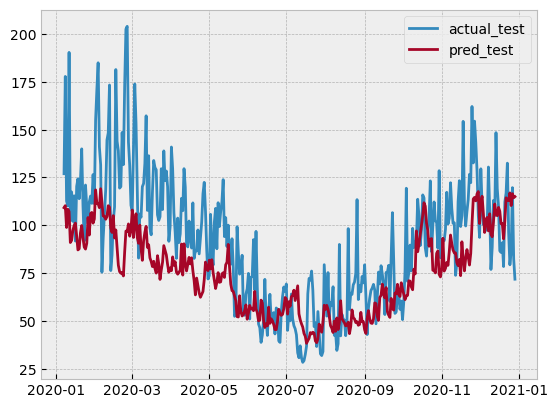

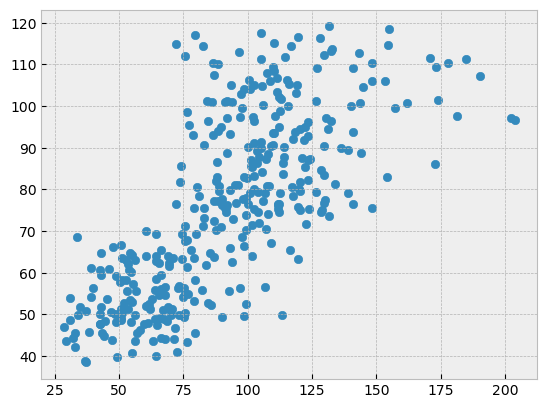

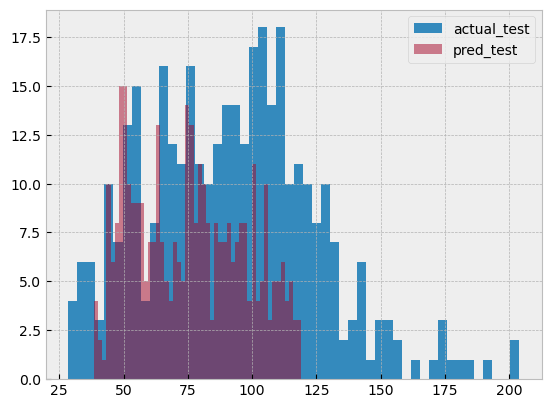

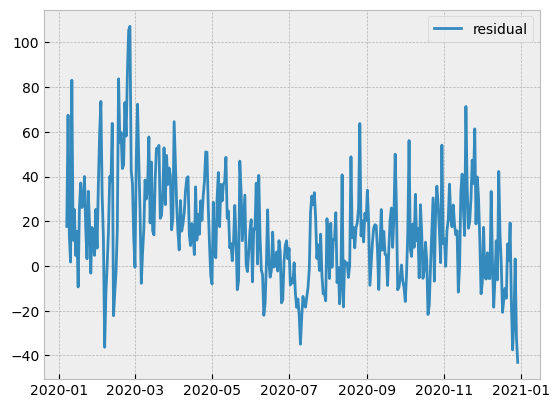

In [38]:
home_num = '522'
X_test, y_test = df_dict_test[home_num][FEATURES], df_dict_test[home_num][TARGET]
pred = model.predict(X_test)
pred_home_test_single = pd.DataFrame({
                            "actual": np.exp(y_train)-0.01,
                            "pred": np.exp(pred)-0.01,
                            "home_num" : home_num})
plt.plot(pred_home_test_single["actual"], label="actual_test")
plt.plot(pred_home_test_single["pred"], label="pred_test")
plt.legend()
plt.show()

plt.scatter(pred_home_test_single["actual"].values,pred_home_test_single["pred"].values) 
plt.show()


plt.hist(pred_home_test_single["actual"], label="actual_test", bins = 50)
plt.hist(pred_home_test_single["pred"], label="pred_test",alpha =0.5, bins = 50)
plt.legend()
plt.show()

plt.plot(pred_home_test_single["actual"]-pred_home_test_single["pred"], label="residual")
plt.legend()
plt.show()

In [39]:
nmae(pred_home_test_single["actual"],pred_home_test_single["pred"])

0.23355712537681733

# Porfolio prediction on Train Data Set

In [40]:
pred_home_train = {}
for home_num in df_dict_train.keys():
    X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
    pred = model.predict(X_train)
    pred_home_train[home_num] = pd.DataFrame({
                                 "actual": np.exp(y_train)-0.01,
                                 "pred": np.exp(pred)-0.01,
                                 "home_num" : home_num})
    

In [41]:
portfolio_actual_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="agg_index").sum(axis=1)

portfolio_pred_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="agg_index").sum(axis=1)

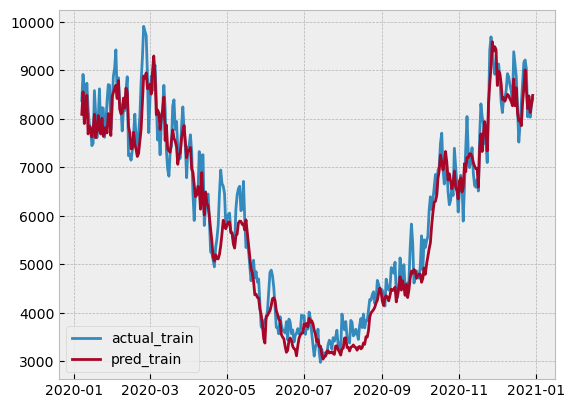

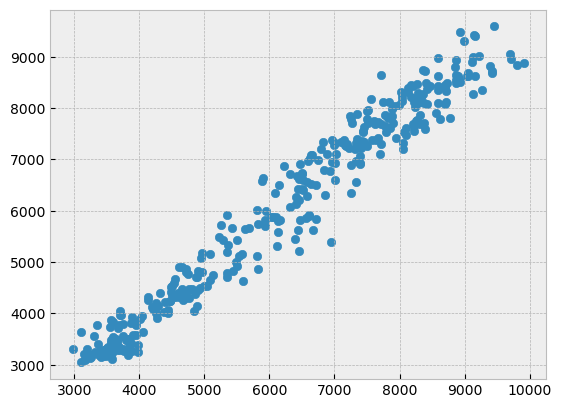

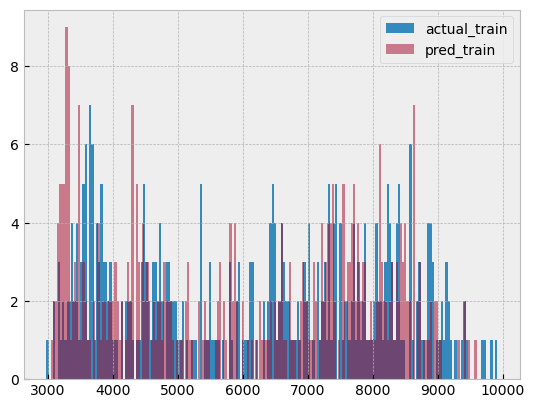

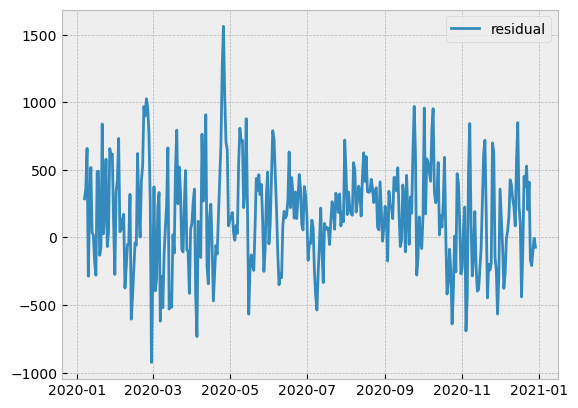

In [42]:
plt.plot(portfolio_actual_train, label="actual_train")
plt.plot(portfolio_pred_train, label="pred_train")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_train, portfolio_pred_train)
plt.show()

plt.hist(portfolio_actual_train, label="actual_train", bins = 200)
plt.hist(portfolio_pred_train, label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

plt.plot(portfolio_actual_train-portfolio_pred_train, label="residual")
plt.legend()
plt.show()

In [43]:
nmae(portfolio_actual_train,portfolio_pred_train)

0.05213632020191849

# Porfolio prediction on Test Data Set

In [44]:
df_dict_test.keys()

dict_keys(['319', '200', '945', '352', '521', '842', '396', '901', '238', '986', '923', '925', '456', '624', '827', '474', '194', '706', '522', '247'])

In [45]:
pred_home_test = {}
for home_num in df_dict_test.keys():
    X_test, y_test = df_dict_test[home_num][FEATURES], df_dict_test[home_num][TARGET]
    pred = model.predict(X_test)
    pred_home_test[home_num] = pd.DataFrame({
                                 "actual": np.exp(y_test)-0.01,
                                 "pred": np.exp(pred)-0.01,
                                 "home_num" : home_num})
    

In [46]:
portfolio_actual_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="agg_index").sum(axis=1)

portfolio_pred_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="agg_index").sum(axis=1)

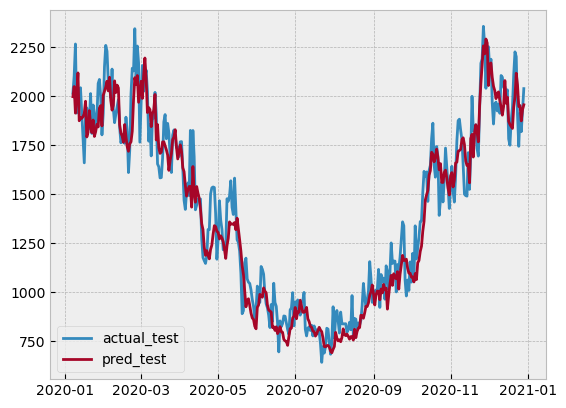

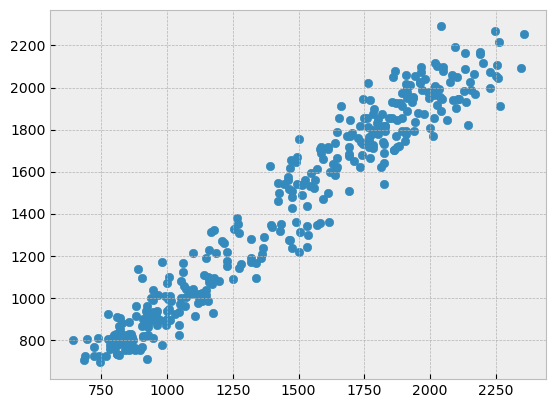

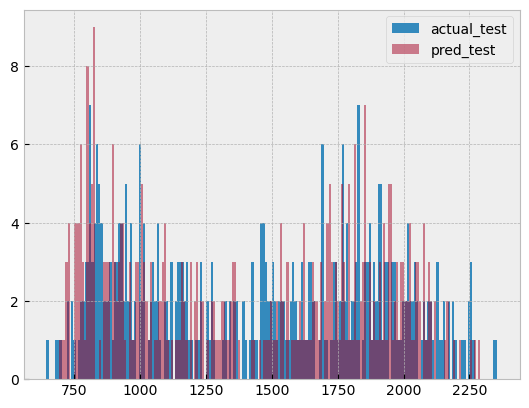

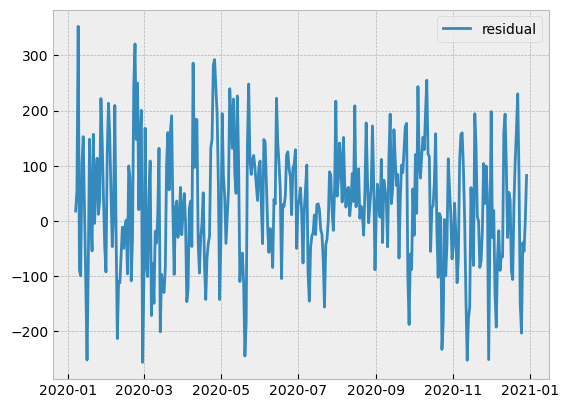

In [47]:
plt.plot(portfolio_actual_test, label="actual_test")
plt.plot(portfolio_pred_test, label="pred_test")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_test, portfolio_pred_test)
plt.show()


plt.hist(portfolio_actual_test, label="actual_test", bins = 200)
plt.hist(portfolio_pred_test, label="pred_test",alpha =0.5, bins = 200)
plt.legend()
plt.show()

plt.plot(portfolio_actual_test-portfolio_pred_test, label="residual")
plt.legend()
plt.show()

In [48]:
nmae(portfolio_actual_test,portfolio_pred_test)

0.06349886916216838

# Decompose to Hourly Consumption Prediction

The most simple model for decomposition from daily to hourly will be just simple ratio per hour time

<BarContainer object of 24 artists>

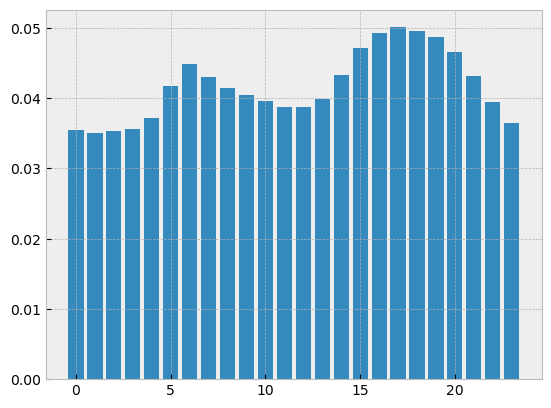

In [49]:
hourly_ratio_con = {}
#better to use another data set (not train nor test) but due to having only 100 samples we will use train
for hom_num in train_homes_indexes_subsample:
    temp_df = data[hom_num].copy()
    temp_df["hour"]=temp_df.reset_index()["time"].dt.hour.values
    hourly_ratio_con[hom_num] = temp_df.groupby("hour")["consumption"].sum()
hourly_ratio_con = (pd.DataFrame(hourly_ratio_con).sum(axis=1) / 
                         pd.DataFrame(hourly_ratio_con).sum(axis=1).sum())
plt.bar(hourly_ratio_con.index, hourly_ratio_con)

In [61]:
hourly_ratio_con = hourly_ratio_con.to_dict()

## Combine Hourly and Daily predictions

#### Create Target for Hourly

In [50]:
target = make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(-48),fe.CastType(float),fe.ApplyLogTransformation())

In [51]:
FULL_TRAINIG_SET = df_dict_train | df_dict_test

def create_samples(home_indexes_subsample):
    df_dict = {}
    for home_i in tqdm.tqdm(list(home_indexes_subsample)):
        if home_i == "268": # outlier
            continue
        temp_df= (data[home_i].
                  copy().
                  reset_index().
                  drop_duplicates(subset='time', keep="last").
                  set_index("time"))
        temp_df = target.fit_transform(temp_df)
        temp_df["time_index"] = temp_df.index.values
        temp_df["date"]=temp_df["time_index"].dt.date.values
        temp_df["hour"]= temp_df["time_index"].dt.hour.values
        temp_df["hour_avg_con_ratio"] = temp_df["hour"].apply(lambda x: hourly_ratio_con[x])
        pred = pd.DataFrame({"pred_daily": model.predict(FULL_TRAINIG_SET[home_i][FEATURES]),
                             "date": FULL_TRAINIG_SET[home_i][TARGET].index
                            })
        
        temp_df=temp_df.merge(pred, left_on ="date", right_on ="date")
        temp_df["pred_hourly"] = (np.exp(temp_df["pred_daily"])-0.01) * temp_df["hour_avg_con_ratio"]
        temp_df["forward_consumption_48"] = np.exp(temp_df["forward_consumption_48"])-0.01
        temp_df["home_i"] = home_i
        df_dict[home_i] = temp_df      
    return df_dict

#Train data
df_dict_train_hourly = create_samples(train_homes_indexes_subsample)

#Test data
df_dict_test_hourly = create_samples(test_homes_indexes_subsample)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.48it/s]


## Model Prediction on Individual House Train

In [52]:
df_dict_train_hourly.keys()

dict_keys(['246', '859', '618', '987', '744', '404', '464', '241', '743', '854', '598', '255', '299', '993', '222', '424', '412', '677', '260', '906', '290', '583', '604', '644', '980', '340', '123', '244', '192', '219', '890', '118', '875', '621', '131', '460', '480', '484', '363', '657', '595', '313', '666', '188', '957', '947', '763', '554', '780', '438', '822', '927', '250', '272', '600', '852', '267', '999', '629', '514', '745', '889', '601', '261', '130', '231', '640', '992', '113', '801', '462', '525', '977', '318', '441', '909', '351', '683', '912'])

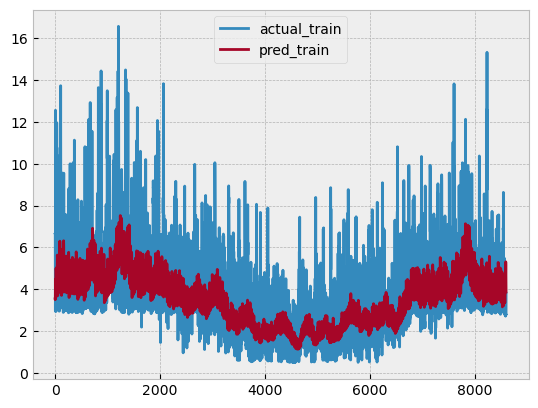

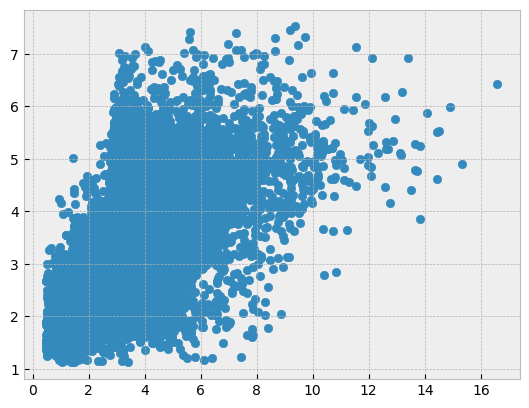

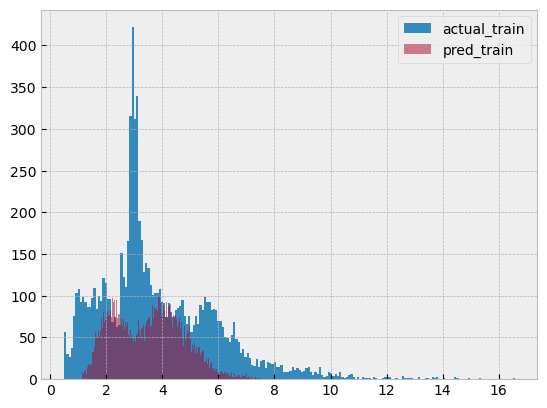

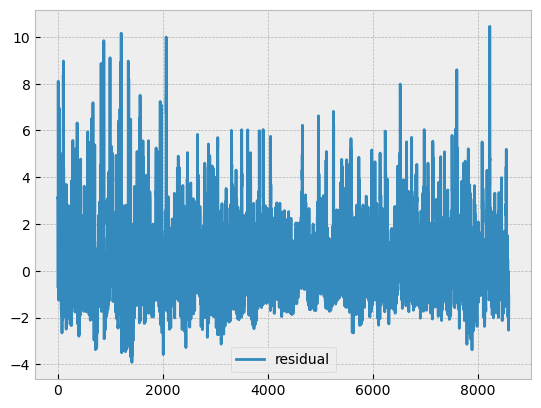

In [54]:
home_num = '246'
pred_home_train_single = pd.DataFrame({
                            "actual": df_dict_train_hourly[home_num]["forward_consumption_48"],
                            "pred": df_dict_train_hourly[home_num]["pred_hourly"],
                            "home_num" : home_num})
plt.plot(pred_home_train_single["actual"], label="actual_train")
plt.plot(pred_home_train_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_train_single["actual"].values,pred_home_train_single["pred"].values) 
plt.show()

plt.hist(pred_home_train_single["actual"], label="actual_train", bins =200)
plt.hist(pred_home_train_single["pred"], label="pred_train",alpha =0.5, bins =200)
plt.legend()
plt.show()

plt.plot(pred_home_train_single["actual"]-pred_home_train_single["pred"], label="residual")
plt.legend()
plt.show()

In [67]:
nmae(pred_home_train_single["actual"], pred_home_train_single["pred"])

0.33125852698367547

## Model Prediction on Individual House Test

In [55]:
df_dict_test_hourly.keys()

dict_keys(['319', '200', '945', '352', '521', '842', '396', '901', '238', '986', '923', '925', '456', '624', '827', '474', '194', '706', '522', '247'])

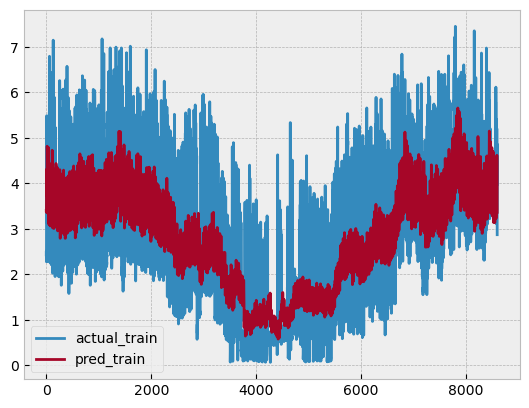

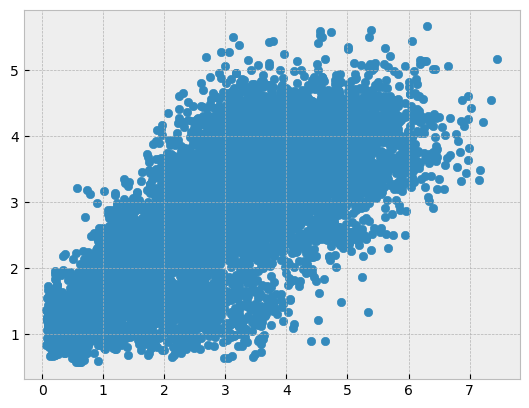

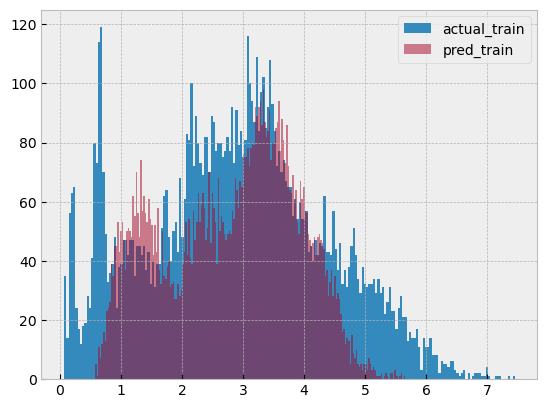

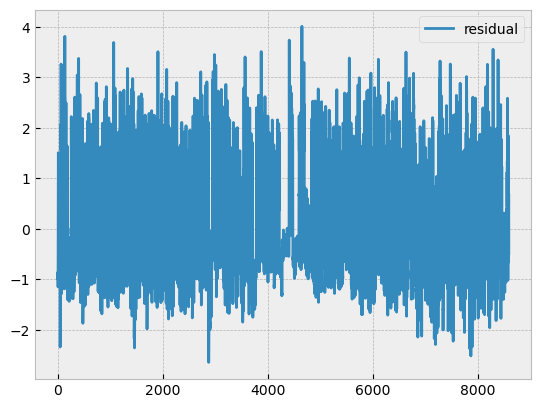

In [56]:
home_num = '319'
pred_home_test_single = pd.DataFrame({
                            "actual": df_dict_test_hourly[home_num]["forward_consumption_48"],
                            "pred": df_dict_test_hourly[home_num]["pred_hourly"],
                            "home_num" : home_num})
plt.plot(pred_home_test_single["actual"], label="actual_train")
plt.plot(pred_home_test_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_test_single["actual"].values,pred_home_test_single["pred"].values) 
plt.show()

plt.hist(pred_home_test_single["actual"], label="actual_train", bins =200)
plt.hist(pred_home_test_single["pred"], label="pred_train",alpha =0.5, bins =200)
plt.legend()
plt.show()

plt.plot(pred_home_test_single["actual"]-pred_home_test_single["pred"], label="residual")
plt.legend()
plt.show()

In [57]:
nmae(pred_home_train_single["actual"], pred_home_train_single["pred"])

0.3311007757005779

# Porfolio prediction on Train Data Set

In [58]:
pred_home_train = {}
for home_num in df_dict_train_hourly.keys():
    pred_home_train[home_num] = pd.DataFrame({
                                 "actual": df_dict_train_hourly[home_num]["forward_consumption_48"],
                                 "pred": df_dict_train_hourly[home_num]["pred_hourly"],
                                 "home_num" : home_num,
                                 "time": df_dict_train_hourly[home_num]["forward_consumption_48"].index})                  

In [59]:
portfolio_actual_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="time").sum(axis=1)

portfolio_pred_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="time").sum(axis=1)

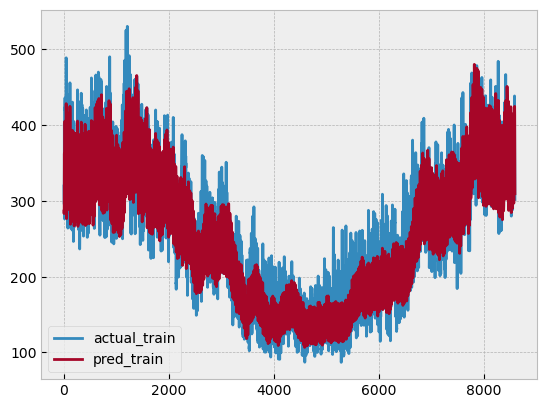

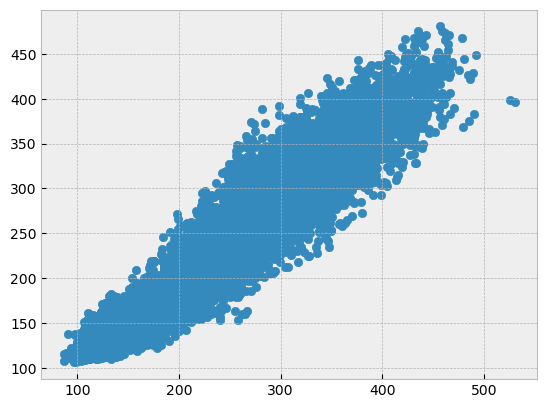

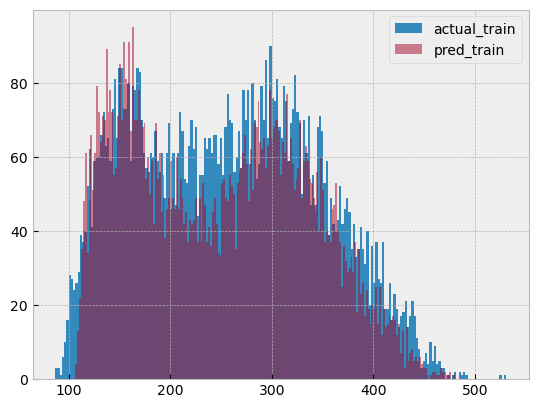

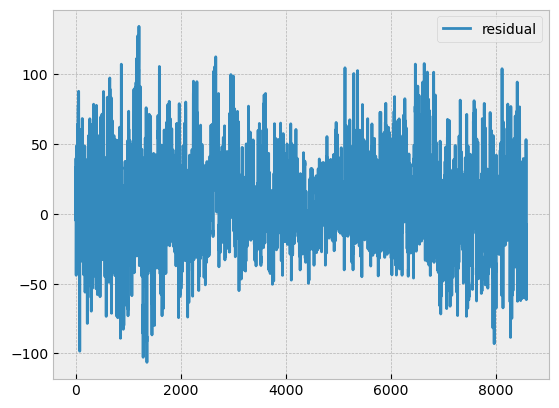

In [60]:
plt.plot(portfolio_actual_train, label="actual_train")
plt.plot(portfolio_pred_train, label="pred_train")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_train, portfolio_pred_train)
plt.show()

plt.hist(portfolio_actual_train, label="actual_train", bins = 200)
plt.hist(portfolio_pred_train, label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

plt.plot(portfolio_actual_train-portfolio_pred_train, label="residual")
plt.legend()
plt.show()

In [61]:
nmae(portfolio_actual_train, portfolio_pred_train)

0.09017822062650106

# Porfolio prediction on Test Data Set

In [62]:
pred_home_test = {}
for home_num in df_dict_test_hourly.keys():
    pred_home_test[home_num] = pd.DataFrame({
                                 "actual": df_dict_test_hourly[home_num]["forward_consumption_48"],
                                 "pred": df_dict_test_hourly[home_num]["pred_hourly"],
                                 "home_num" : home_num,
                                 "time": df_dict_test_hourly[home_num]["forward_consumption_48"].index})

In [63]:
portfolio_actual_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="time").sum(axis=1)

portfolio_pred_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="time").sum(axis=1)

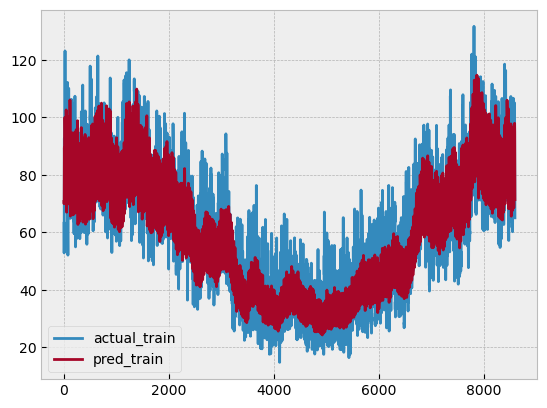

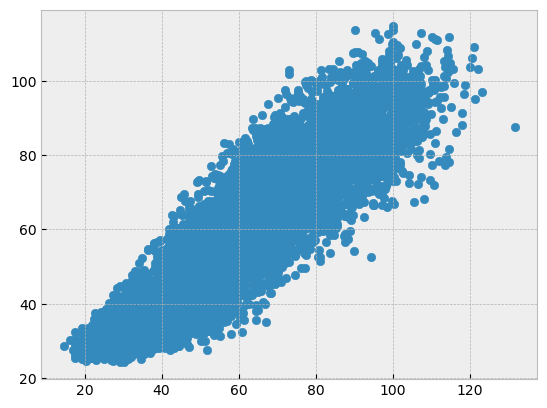

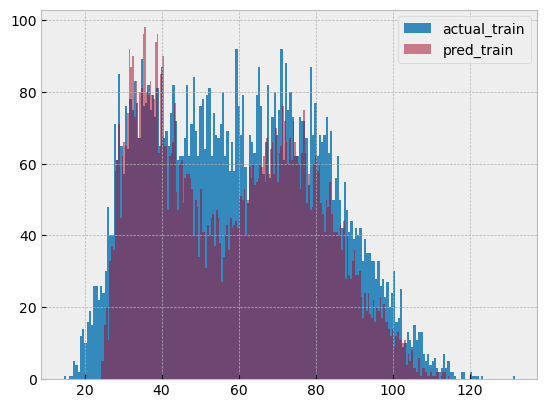

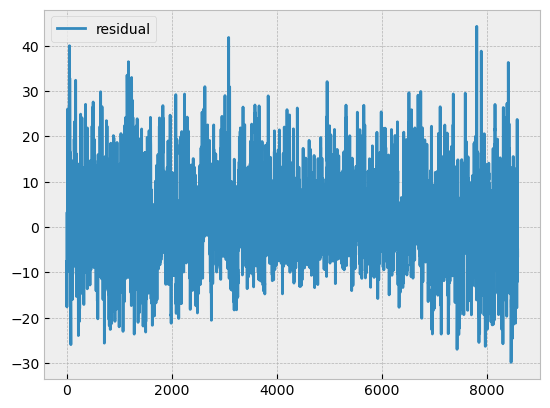

In [64]:
plt.plot(portfolio_actual_test, label="actual_train")
plt.plot(portfolio_pred_test, label="pred_train")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_test, portfolio_pred_test)
plt.show()

plt.hist(portfolio_actual_test, label="actual_train", bins = 200)
plt.hist(portfolio_pred_test, label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

plt.plot(portfolio_actual_test-portfolio_pred_test, label="residual")
plt.legend()
plt.show()

In [65]:
nmae(portfolio_actual_test, portfolio_pred_test)

0.11994693974095591